<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Qichen(Lead), Paritosh, Rawal, Yan, Zen, Wen-Hsuan

## Q4 Extract Text from Images (35 points)

**Please include all the write up answers below to theory.ipynb. For the questions need code, you need to include the screenshot of code to theory.ipynb to get points.**

![](figures/annotatedLetters.jpg)
<center>Sample image with handwritten characters annotated with boxes around each character</center>

Now that you have a network that can recognize handwritten letters with reasonable accuracy, you can now use it to parse text in an image. Given an image with some text on it, our goal is to have a function that returns the actual text in the image. However, since your neural network expects a a binary image with a single character, you will need to process the input image to extract each character. There are various approaches that can be done so feel free to use any strategy you like.

Here we outline one possible method, another is that given in a [tutorial](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)
1. Process the image ([blur](http://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html), [threshold](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.try_all_threshold), [opening morphology](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.opening), etc. (perhaps in that order)) to classify all pixels as being part of a character or background.
2. Find connected groups of character pixels (see [skimage.measure.label](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label)). Place a bounding box around each connected component.
3. Group the letters based on which line of the text they are a part of, and sort each group so that the letters are in the order they appear on the page.
4. Take each bounding box one at a time and resize it to $32\times 32$, classify it with your network, and report the characters in order (inserting spaces when it makes sense).

Since the network you trained likely does not have perfect accuracy, you can expect there to be some errors in your final text parsing. Whichever method you choose to implement for the character detection, you should be able to place a box on most of there characters in the image. We have provided you with **01\_list.jpg**, **02\_letters.jpg**, **03\_haiku.jpg** and **04\_deep.jpg** to test your implementation on.

### Q4.1 (3 points WriteUp)
The method outlined above is pretty simplistic, and makes several assumptions. What are two big assumptions that the sample method makes. In your writeup, include two example images where you expect the character detection to fail (either miss valid letters, or respond to non-letters).

<font color="red">**Please include the write up answer to theory.ipynb**</font>

### Q4.2 (13 points Code+WriteUp)
Find letters in the image. Given an RGB image, this function should return bounding boxes for all of the located handwritten characters in the image, as well as a binary black-and-white version of the image \texttt{im}. Each row of the matrix should contain **[y1,x1,y2,x2]** the positions of the top-left and bottom-right corners of the box. The black and white image should be floating point, 0 to 1, with the characters in black and background in white. 

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [1]:
import numpy as np
import os

import skimage
import skimage.measure
import skimage.color
import skimage.restoration
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation

# takes a color image
# returns a list of bounding boxes and black_and_white image
def findLetters(image, sigma=2.0):

    # insert processing in here
    # one idea estimate noise -> denoise -> greyscale -> threshold -> morphology -> label -> skip small boxes 
    # this can be 10 to 15 lines of code using skimage functions
    # YOUR CODE HERE    
    blurred = skimage.filters.gaussian(image, sigma=(sigma, sigma), truncate=3.0, multichannel=True)
    gray = skimage.color.rgb2gray(blurred)
    binary = gray > skimage.filters.threshold_otsu(gray)

    # Thicken the characters up a bit depending on the image size
    thick_scalar = int(5 * max(binary.shape) / 1600)
    thicker = skimage.morphology.binary_erosion(
        binary, selem=np.ones((thick_scalar, thick_scalar))
    )
    labelled = skimage.measure.label(thicker, background=True, connectivity=2)
    regions = skimage.measure.regionprops(labelled)

    # Decide which size of boxes to drop based on the median character size
    area_threshold = 0.2 * np.median([region.area for region in regions])
    bboxes = [region.bbox for region in regions if region.area > area_threshold]

    return bboxes, binary.astype(float)


# from matplotlib import pyplot
# import skimage.draw
# for image_path in os.listdir('images'):
#     print(image_path)
#     image = skimage.io.imread(os.path.join('images', image_path))
#     bboxes, bw = findLetters(image)
#     skimage.io.imsave(image_path.replace(".", "BW."), (bw * 255).astype(np.uint8))
#     pyplot.imshow(bw, interpolation='none')
#     pyplot.show()
#     for bbox in bboxes:
#         rows, columns = skimage.draw.rectangle_perimeter(
#             bbox[0:2], end=bbox[2:], shape=image.shape
#         )
#         image[rows, columns] = (255, 0, 0)
#     skimage.io.imsave(image_path.replace(".", "BOX."), image)
#     pyplot.imshow(image)
#     pyplot.show()

### Q4.3 (6 points Code+WriteUp)
Run `findLetters()` on all of the provided sample images in **images/**. Plot all of the located boxes on top of the image to show the accuracy of your `findLetters()` function. Include all the result images in your writeup.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

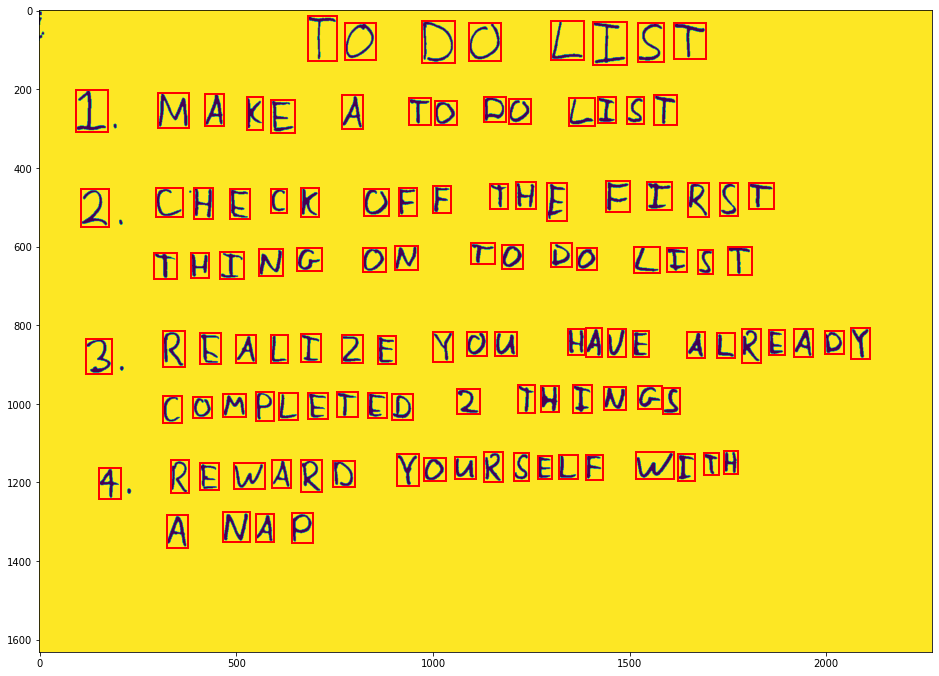

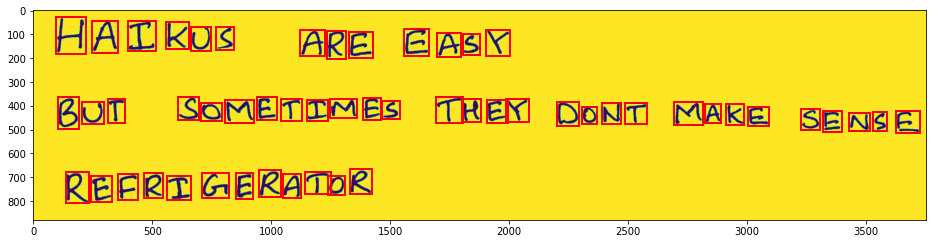

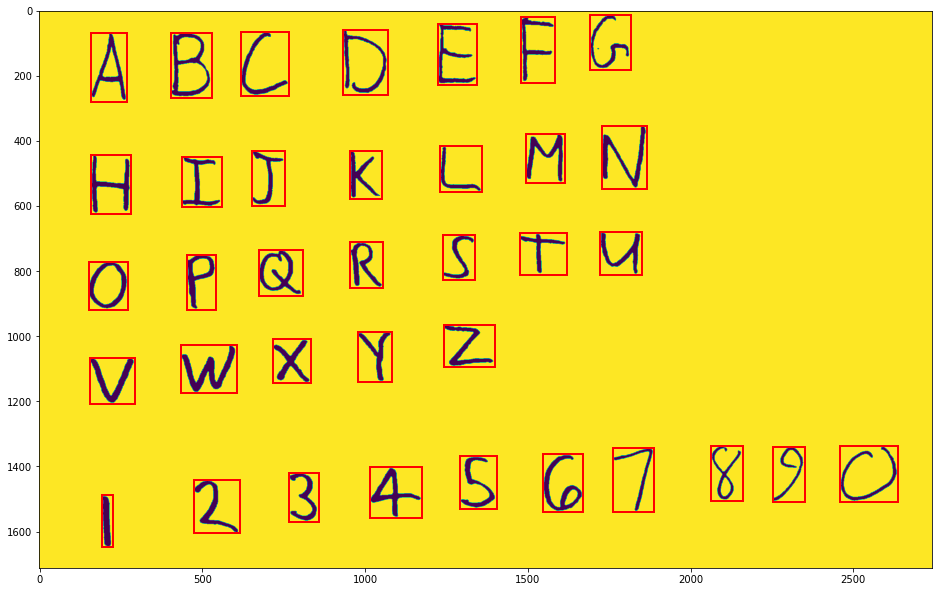

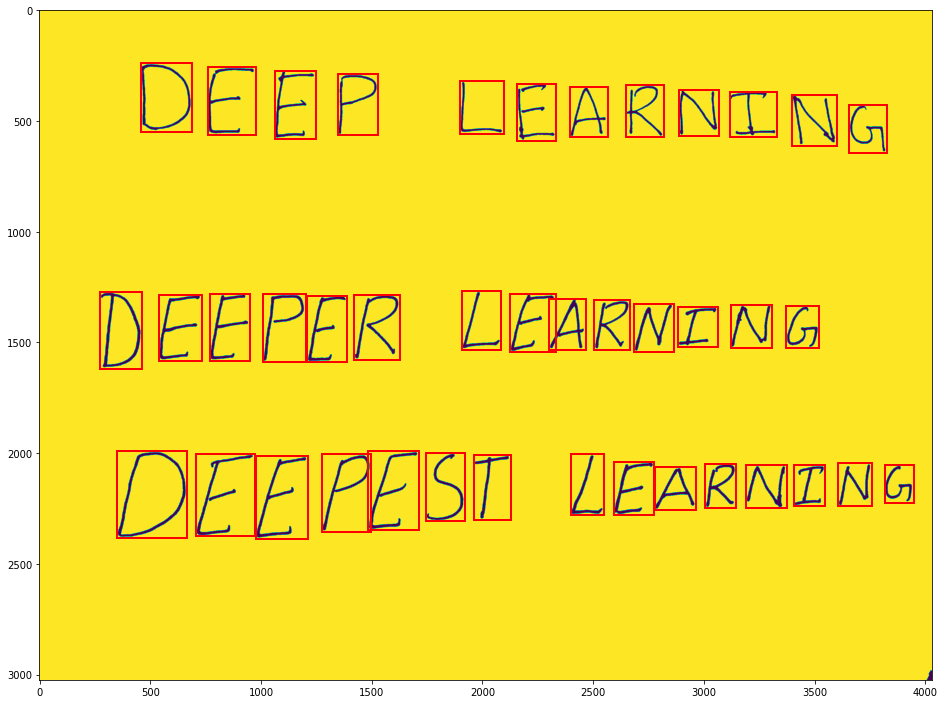

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches

from ipynb.fs.defs.q2 import *

# do not include any more libraries here!
# no opencv, no sklearn, etc!
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


def get_row_groups(num_rows, bboxes):
    """
    Get row groupings of bboxes, assuming there's at least one horizontal pixel
    between each row. This won't handle slanted rows, which should be fine
    since those don't appear to show up in the input images.
    """
    # Figure out which rows act as dividers, crossing the whole image without
    # encountering a box
    rows = np.array(range(num_rows))
    for bbox in bboxes:
        rows[bbox[0]:bbox[2]+1] = -1
    dividers = np.argwhere( (rows > 0)[:-1] & (rows < 0)[1:] ).T[0]
    dividers = np.hstack((dividers, [num_rows]))
    # Figure out which row each box is in
    # This is a double loop, but it's also over ~50 items and ~8, so I
    # won't bother compressing it
    row_groups = []
    for i in range(len(dividers) - 1):
        row_group = []
        for bbox in bboxes:
            if dividers[i] < bbox[0] < dividers[i+1]:
                row_group.append(bbox)
        # Sort the boxes so they go in increasing horizontal value
        row_groups.append(sorted(row_group, key=lambda x: x[1]))
    return dividers, row_groups


def pretty_letters(binary, row_groups):
    """
    Returns a set of 32x32 images of the same layout as row_groups.
    """
    image_groups = []
    for row in row_groups:
        image_row = []
        for bbox in row:
            raw = binary[bbox[0]:bbox[2], bbox[1]:bbox[3]].astype(float)
            buffer = 2 * max(raw.shape) // 32
            hpad = buffer + (max(raw.shape) - raw.shape[0]) // 2
            wpad = buffer + (max(raw.shape) - raw.shape[1]) // 2
            padded = np.pad(raw,
                            pad_width=((hpad, hpad), (wpad, wpad)),
                            mode='constant',
                            constant_values=1.0)
            im32 = skimage.transform.resize(padded, (32, 32), anti_aliasing=True)
            # SET THE VALUES TO BE A LITTLE LOWER THAN 1
            # The real images look a little darker in the background
            im32[im32 > 0.93] = 0.93
            # In a loop, make the images look the "proper" proportion of dark. The 0.78
            # number comes from the average value of the real numbers
            while np.average(im32) > 0.78:
                padded = skimage.morphology.erosion(padded)
                im32 = skimage.transform.resize(padded, (32, 32), anti_aliasing=True)
                im32[im32 > 0.93] = 0.93
            # Append the transposed image
            image_row.append(im32.T)
        image_groups.append(image_row)
    return image_groups


for img in os.listdir('images'):
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images', img)))
    bboxes, bw = findLetters(im1)

    figure = plt.figure(figsize=(16, 16))
    plt.imshow(bw)
    for bbox in bboxes:
        minr, minc, maxr, maxc = bbox
        rect = matplotlib.patches.Rectangle(
            (minc, minr), maxc - minc, maxr - minr,
            fill=False, edgecolor='red', linewidth=2
        )
        plt.gca().add_patch(rect)
    plt.show()
    # plt.savefig(img.replace(".", "BOX."))
    # plt.close(figure)

    # find the rows using..RANSAC, counting, clustering, etc.
    # YOUR CODE HERE
    _, row_groups = get_row_groups(bw.shape[0], bboxes)

    # crop to the bounding boxes
    # note.. before you flatten, transpose the image (that's how the dataset is!)
    # consider doing a square crop, and even using np.pad() to get your images looking more like the dataset
    # YOUR CODE HERE
    image_groups = pretty_letters(bw, row_groups)


### Q4.4 (13 points Code+WriteUp)
Now you will load the image, find the character locations, classify each one with the network you trained in **Q3.1**, and return the text contained in the image. Be sure you try to make your detected images look like the images from the training set. Visualize them and act accordingly. 

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

Average proportion of real usage images that are background: 0.7586470659193802


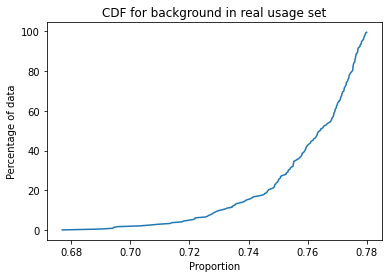

Average proportion of test images that are background: 0.7910111474757953


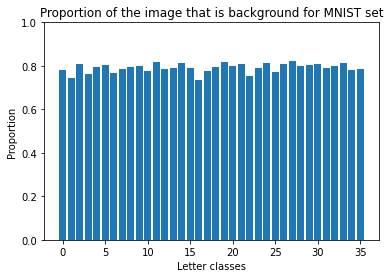

In [8]:
# Added code to investigate the original images
import scipy.io
from matplotlib import pyplot
test_data = scipy.io.loadmat('data/nist36_test.mat')
test_x, test_y = test_data['test_data'], test_data['test_labels']

# for i, vector in enumerate(test_x):
#     skimage.io.imsave(f"eric_images/test_set_{i}.png",
#                       (vector * 255).astype(np.uint8).reshape((32, 32)))

counter = 0
real_usage_proportions = []
for img in os.listdir('images'):
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images', img)))
    bboxes, bw = findLetters(im1)
    _, row_groups = get_row_groups(bw.shape[0], bboxes)
    image_groups = pretty_letters(bw, row_groups)
    for image_row in image_groups:
        for image in image_row:
            if np.average(image) < 0.5: import ipdb; ipdb.set_trace()
            real_usage_proportions.append(np.average(image))
            skimage.io.imsave(f"eric_images/real_usage_{counter}.png",
                              (image * 255).astype(np.uint8))
            skimage.io.imsave(f"eric_images/real_transposed_usage_{counter}.png",
                              (image.T * 255).astype(np.uint8))
            counter += 1
print(f"Average proportion of real usage images that are background: {np.average(real_usage_proportions)}")
pyplot.plot(sorted(real_usage_proportions),
            np.arange(len(real_usage_proportions)) * 100/len(real_usage_proportions))
pyplot.title("CDF for background in real usage set")
pyplot.xlabel("Proportion")
pyplot.ylabel("Percentage of data")
pyplot.show()

# Measure proportion per class
from matplotlib import pyplot
proportions = [[] for _ in range(test_y.shape[1])]
for x, y in zip(test_x, test_y):
    proportions[np.argmax(y)].append(np.average(x))
for i in range(len(proportions)):
    proportions[i] = np.average(proportions[i])
print(f"Average proportion of test images that are background: {np.average(proportions)}")
pyplot.bar(range(len(proportions)), proportions)
pyplot.ylim(0, 1)
pyplot.title("Proportion of the image that is background for MNIST set")
pyplot.xlabel("Letter classes")
pyplot.ylabel("Proportion")
pyplot.show()

# TODO: Look into the proportion of values between 0 and 1...

In [3]:
### load the weights
# run the crops through your neural network and print them out
import pickle
import string
import numpy as np

from ipynb.fs.defs.q2 import *


def classify(params, image, letters):
    y1 = forward(image.reshape(1, 32*32), params, "layer1", sigmoid)
    probs = forward(y1, params, "output", softmax)
    return letters[np.argmax(probs)]


letters = np.array([c for c in string.ascii_uppercase[:26]] + [str(n) for n in range(10)])
params = pickle.load(open('q3_weights.pickle','rb'))
# YOUR CODE HERE
characters = []
for img in os.listdir('images'):
    print(f"{img}")
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images', img)))
    bboxes, bw = findLetters(im1)
    _, row_groups = get_row_groups(bw.shape[0], bboxes)
    image_groups = pretty_letters(bw, row_groups)
    for image_row in image_groups:
        characters.append([classify(params, image, letters) for image in image_row])
        print(" ".join(characters[-1]))

flattened = np.array(sum(characters, start=[]))
correct = np.array(
    list("TODOLIST1MAKEATODOLIST2CHECKOFFTHEFIRSTTHINGONTODOLIST" +
         "3REALIZEYOUHAVEALREADYCOMPLETED2THINGS4REWARDYOURSELFWITHANAP" +
         "ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890" +
         "HAIKUSAREEASYBUTSOMETIMESTHEYDONTMAKESENSEREFRIGERATOR" +
         "DEEPLEARNINGDEEPERLEARNINGDEEPESTLEARNING")
)
print(f"\nLength equal? {flattened.shape} == {correct.shape} ? {flattened.shape == correct.shape}")
minlen = min(len(flattened), len(correct))
print(f"Accuracy: {np.sum(flattened[:minlen] == correct[:minlen]) / len(correct)}")

01_list.jpg
T 0 D O L I S T
I N A X E A T D D O L I S T
2 C H 2 C K U F F 7 H E F I R S T
T P I N G 0 N T 0 U 0 L I S T
Z R 2 A L I Z E Y 0 U H A V E A L R 2 A D T
C 0 M P L F T E D Z Y H I N G S
4 R E W A R D Y 0 U R S E L F W I T H
A N A P
03_haiku.jpg
H A I K U S A R E E A S Y
E W T S Q M E T I M E S T H E Y D D W T M A K E S E N G E
R B F R I G E R A T 0 R
02_letters.jpg
A B C D E F G
H I J K L M N
0 P Q K S T V
V W X Y Z
1 Z 3 M S G 7 8 9 S
04_deep.jpg
D E E P L E A R M I N G
D E P P E R L E A K N I N G
D E E R E S T L E A R N I N G

Length equal? (246,) == (246,) ? True
Accuracy: 0.5365853658536586
